# Detector de língua

## Objetivo

Elaborar uma estratégia e construa um sistema que seja capaz de responder a qual idioma uma frase qualquer pertence.

Por Exemplo:

`eu gosto de café` → `por`

`I like coffee`→ `eng`

## Bibliotecas

In [30]:
# manipulação de dados
import pandas as pd

# manipulação de texto

# modelo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# exportar o modelo
import joblib

## Base de Dados

Dessa vez encontrei uma base de dados contendo frases em seus respectivos idiomas Afrikaans, English e Nederlands (africano, inglês e holandês). Queria achar alguma em português mas não consegui.

Disponível no seguinte repositório do github: https://github.com/rolandgem/LanguageClassification/tree/main

## Leitura dos dados 

In [2]:
df = pd.read_csv('lang_data.csv')
df.head()

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [3]:
df

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English
...,...,...
2834,Daar’s ‘n geurtjie aan.,Afrikaans
2835,Men's evil manners live in brass; their virtue...,English
2836,Go-faster,English
2837,Red tape,English


In [4]:
df.shape

(2839, 2)

In [5]:
df.duplicated().sum()

84

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

text        3
language    0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

text        0
language    0
dtype: int64

In [9]:
df.shape

(2752, 2)

In [10]:
percentual_lingua = df['language'].value_counts(normalize=True) * 100
percentual_lingua


English       74.382267
Afrikaans     23.183140
Nederlands     2.434593
Name: language, dtype: float64

**Temos muito pouca amostra de textos em holandês**

## Preparação dos textos

### Stop Words

Aqui teremos que separar as 3 línguas e usar pacotes para remover as stop words dos 3 idiomas distintos.

In [11]:
df1 = df.copy()

df_africano = df1[df1['language'] == 'Afrikaans']
df_ingles = df1[df1['language'] == 'English']
df_holandes = df1[df1['language'] == 'Nederlands']

Encontrei os stop words no repositório do github -> https://github.com/6/stopwords-json?tab=readme-ov-file

Tentei usar o pacote nltk, mas acho que eles não tem para africanos e holandeses então resolvi usar o que tem todos no mesmo lugar.

In [12]:
# Começando com os africanos
with open('stop_words/afrikaans_stopwords.txt', 'r', encoding='utf-8') as arquivo:
    stopwords_lista = arquivo.read().splitlines()

# Função para remover as stop words do texto
def remover_stopwords(texto):
    palavras = texto.split()
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stopwords_lista]
    return ' '.join(palavras_sem_stopwords)


df_africano['text'] = df_africano['text'].apply(remover_stopwords)

df_africano.head()

C:\Users\Ben-Hur\AppData\Local\Temp\ipykernel_15004\399999869.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_africano['text'] = df_africano['text'].apply(remover_stopwords)


,text,language
5,Sy kan altyd my battery natpiepie.,Afrikaans
16,Piet Pompies van Soetmelksvlei is nie van hier...,Afrikaans
28,Die lewe is 10 % wat met ons gebeur en 90 % on...,Afrikaans
31,"Saam met ons, rondom ons, in ons en by ons is ...",Afrikaans
35,"Vroeg uit die bed, maak die beursie vet!",Afrikaans


In [13]:
# Inglês
with open('stop_words/english_stopwords.txt', 'r', encoding='utf-8') as arquivo:
    stopwords_lista = arquivo.read().splitlines()

# Função para remover as stop words do texto
def remover_stopwords(texto):
    palavras = texto.split()
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stopwords_lista]
    return ' '.join(palavras_sem_stopwords)


df_ingles['text'] = df_ingles['text'].apply(remover_stopwords)

df_ingles.head()

C:\Users\Ben-Hur\AppData\Local\Temp\ipykernel_15004\3200920810.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ingles['text'] = df_ingles['text'].apply(remover_stopwords)


,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [14]:
# Holandês
with open('stop_words/nederlands_stopwords.txt', 'r', encoding='utf-8') as arquivo:
    stopwords_lista = arquivo.read().splitlines()

# Função para remover as stop words do texto
def remover_stopwords(texto):
    palavras = texto.split()
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stopwords_lista]
    return ' '.join(palavras_sem_stopwords)


df_holandes['text'] = df_holandes['text'].apply(remover_stopwords)

df_holandes.head()

C:\Users\Ben-Hur\AppData\Local\Temp\ipykernel_15004\3793866697.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holandes['text'] = df_holandes['text'].apply(remover_stopwords)


,text,language
64,"Je moet geen oude schoenen weggooien, voordat ...",Nederlands
93,"Wie zaait, zal oogsten.",Nederlands
119,"Wie het eerst komt, het eerst maalt.",Nederlands
143,Gedane zaken nemen geen keer.,Nederlands
170,Aan alles komt een eind.,Nederlands


### Juntandos os dataframes de volta

In [15]:
df_stop = pd.concat([df_africano, df_ingles, df_holandes])
df_stop

,text,language
5,Sy kan altyd my battery natpiepie.,Afrikaans
16,Piet Pompies van Soetmelksvlei is nie van hier...,Afrikaans
28,Die lewe is 10 % wat met ons gebeur en 90 % on...,Afrikaans
31,"Saam met ons, rondom ons, in ons en by ons is ...",Afrikaans
35,"Vroeg uit die bed, maak die beursie vet!",Afrikaans
...,...,...
2516,De laatste druppel doet de emmer overlopen.,Nederlands
2751,Kleine potjes hebben grote oren.,Nederlands
2776,Schijn bedriegt.,Nederlands
2797,Iets is beter dan niets.,Nederlands


In [16]:
#df_stop.to_csv('stop_words.csv', index=False)

## Representação Bag of Word

In [17]:
countvec = CountVectorizer(ngram_range = (1,2))
countvec_data = countvec.fit_transform(df_stop['text'])

In [18]:
# Conversão da matriz esparsa para DataFrame
df_bow = pd.DataFrame(countvec_data.toarray(), 
                      columns=countvec.get_feature_names_out())
df_bow.index = df_stop.index
df_bow = df_bow.join(df_stop[['language']], how='left')
df_bow.head()


,10,10 wat,1500s,1500s folk,1ste,1ste graad,22,90,90 ons,99,...,zwijgen is,àugur,àugur well,één,één ding,één klap,één paard,één rede,één vogel,language
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Afrikaans
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Afrikaans
28,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,Afrikaans
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Afrikaans
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Afrikaans


# Criação do modelo 

In [19]:
language_map = {'Afrikaans': 0, 'English':1, 'Nederlands':2}
df_bow['language'] = df_bow['language'].map(language_map)
df_bow.head()

,10,10 wat,1500s,1500s folk,1ste,1ste graad,22,90,90 ons,99,...,zwijgen is,àugur,àugur well,één,één ding,één klap,één paard,één rede,één vogel,language
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Definição do target e features

In [20]:
# Target 
y = df_bow['language']

# Features
x = df_bow.drop('language', axis=1)

## Divisão treino e teste

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [22]:
(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((1926, 13375), (826, 13375), (1926,), (826,))

## Criação de treinamento do modelo 

In [23]:
modelo = GradientBoostingClassifier(n_estimators=100,
                                        subsample=0.5,
                                        random_state=42)
modelo.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42, subsample=0.5)

In [24]:
y_pred = modelo.predict(x_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.9297820823244553


In [26]:
confusion_matrix(y_test, y_pred)

array([[153,  40,   0],
       [  1, 610,   0],
       [  0,  17,   5]], dtype=int64)

# Exportando o modelo

In [27]:
# Exportando o modelo para um arquivo
joblib.dump(modelo, 'modelo.pkl')

['modelo.pkl']

# Testando o modelo com frases inputadas 

In [28]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer



# Carregando os stop words
df_stop = pd.read_csv('stop_words.csv')

# Carregando o modelo a partir do arquivo
modelo = joblib.load('modelo.pkl')


frase = input("Digite uma frase: ")

# Ajustar o CountVectorizer
countvec = CountVectorizer(ngram_range=(1, 2))
countvec.fit(df_stop['text'])

# Vetorização da frase de teste usando o mesmo CountVectorizer ajustado
frase_vetorizada = countvec.transform([frase])

# Fazer a previsão
classe_prevista = modelo.predict(frase_vetorizada)
print("A frase foi classificada como:", classe_prevista)



Digite uma frase: alo
A frase foi classificada como: [1]


C:\Users\Ben-Hur\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


# Testando novos modelos de Redes Neurais

Como eu já tinha uma base de dados boa, não preciso ir atrás de outra, texto já está preparado, base de treino e teste dividido agora é só treinar o modelo

In [47]:
# Inicialização do modelo_rnao
modelo_rna = keras.Sequential()

# 1a camada oculta
modelo_rna.add(layers.Dense(10, activation='tanh', input_dim=x_train.shape[1]))
modelo_rna.add(layers.Dropout(0.2))

# 2a camada oculta
modelo_rna.add(layers.Dense(8, activation='tanh'))
modelo_rna.add(layers.Dropout(0.1))

# camada de saída
modelo_rna.add(layers.Dense(3, activation='softmax'))

# Compilando o modelo_rnao
modelo_rna.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Exibindo o resumo do modelo_rnao
modelo_rna.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                133760    
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 88        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 3)                 27        
                                                                 
Total params: 133,875
Trainable params: 133,875
Non-trainable params: 0
_________________________________________________________________


In [48]:
historico = modelo_rna.fit(x=x_train, 
                           y=y_train,
                           epochs=100,
                           batch_size=32,
                           validation_split=0.1,
                           verbose=1)

Epoch 1/100
55/55 [==============================] - 1s 6ms/step - loss: 0.9222 - accuracy: 0.7421 - val_loss: 0.7159 - val_accuracy: 0.9275
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5834 - accuracy: 0.8898 - val_loss: 0.4123 - val_accuracy: 0.9534
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 0.3406 - accuracy: 0.9406 - val_loss: 0.2399 - val_accuracy: 0.9689
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1974 - accuracy: 0.9752 - val_loss: 0.1606 - val_accuracy: 0.9793
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9833 - val_loss: 0.1194 - val_accuracy: 0.9793
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 0.0896 - accuracy: 0.9890 - val_loss: 0.0960 - val_accuracy: 0.9793
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.9937 - val_loss: 0.0809 - val_accuracy: 0.9793
Epoch 8/100
5

Epoch 59/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0403 - val_accuracy: 0.9845
Epoch 60/100
55/55 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0403 - val_accuracy: 0.9845
Epoch 61/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9845
Epoch 62/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9845
Epoch 63/100
55/55 [==============================] - 0s 3ms/step - loss: 9.8411e-04 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 0.9845
Epoch 64/100
55/55 [==============================] - 0s 4ms/step - loss: 7.6744e-04 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9845
Epoch 65/100
55/55 [==============================] - 0s 4ms/step - loss: 7.9765e-04 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0

In [49]:
# Avaliação do modelo
resultado_teste = modelo_rna.evaluate(x_test, y_test, verbose=0)

# Acurácia
acuracia = resultado_teste[1]
print("Acurácia do modelo:", round((acuracia*100),2), "%")

Acurácia do modelo: 97.09 %


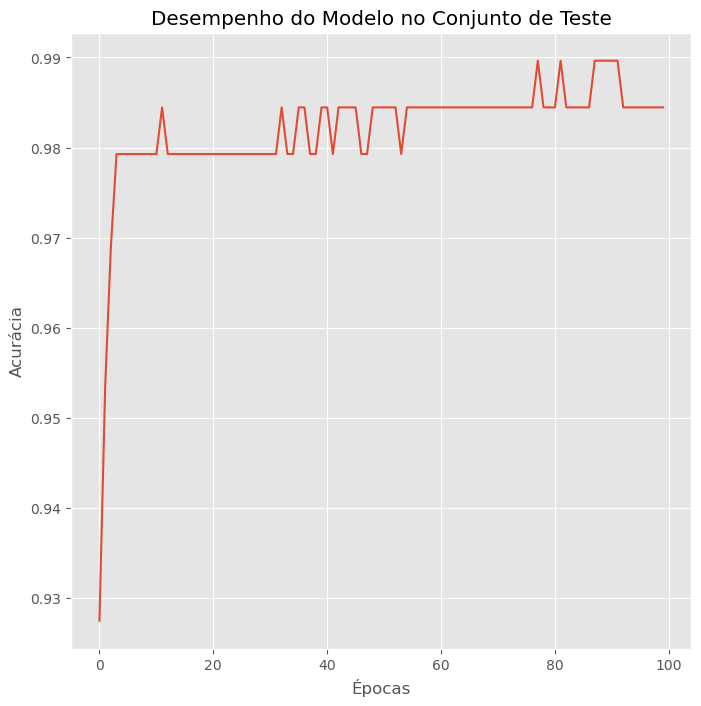

In [50]:
# Pacotes gráficos
%matplotlib inline
import matplotlib.pyplot as plt

# Acurácia do teste
acuracia_teste = historico.history['val_accuracy']

# Gráfico com a evolução do treinamento
plt.figure(figsize=(8, 8))
plt.style.use('ggplot')
plt.plot(acuracia_teste)
plt.title('Desempenho do Modelo no Conjunto de Teste')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.show()


**Acho que estamos próximo de um overfit, vamos ajustar as épocas ao testar os parametros**

###  Melhorando os hiperparamentros

In [51]:
def treina_rna(x_train, y_train, x_test, y_test, nnc1, nnc2):
    # Definição do Modelo RNA
    model = keras.Sequential([
        layers.Dense(nnc1, activation='relu', input_dim=x_train.shape[1]),
        layers.Dense(nnc2, activation='relu'),
        layers.Dense(3, activation='softmax')  # Ajuste para 3 classes de saída
    ])

    # Compilação do Modelo
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    # Treinamento do Modelo RNA
    historico = model.fit(x=x_train, 
                          y=y_train,
                          epochs=50,  # Reduzindo para 50 épocas
                          batch_size=32,
                          validation_split=0.1,
                          verbose=0)

    # Avaliação do Desempenho do Modelo RNA no conjunto de teste
    _, metric_test = model.evaluate(x_test, y_test, verbose=0)

    return model, metric_test


In [56]:
%%time
lst_models = list()
lst_nnc1 = list()
lst_nnc2 = list()
acc_test = list()

id_model = 0
for nnc1 in range(8, 12):
    for nnc2 in range(8, 12):
        print(f'Treinando Modelo {id_model}')
        lst_nnc1.append(nnc1)
        lst_nnc2.append(nnc2)
        modelo, acc = treina_rna(x_train, y_train, 
                                 x_test, y_test,
                                 nnc1, nnc2)
        lst_models.append(modelo)
        acc_test.append(acc)
        id_model += 1


Treinando Modelo 0
Treinando Modelo 1
Treinando Modelo 2
Treinando Modelo 3
Treinando Modelo 4
Treinando Modelo 5
Treinando Modelo 6
Treinando Modelo 7
Treinando Modelo 8
Treinando Modelo 9
Treinando Modelo 10
Treinando Modelo 11
Treinando Modelo 12
Treinando Modelo 13
Treinando Modelo 14
Treinando Modelo 15
Wall time: 2min 37s


In [57]:
busca_rna = pd.DataFrame(list(zip(lst_nnc1, lst_nnc2, acc_test, lst_models)), 
                        columns=['Num Neuronios C1',
                                 'Num Neuronios C2',
                                 'Accuracy Test',
                                 'Modelo'
                                ])

busca_rna.sort_values('Accuracy Test', ascending=False)

,Num Neuronios C1,Num Neuronios C2,Accuracy Test,Modelo
10,10,10,0.976998,<keras.engine.sequential.Sequential object at ...
9,10,9,0.970944,<keras.engine.sequential.Sequential object at ...
5,9,9,0.967312,<keras.engine.sequential.Sequential object at ...
6,9,10,0.967312,<keras.engine.sequential.Sequential object at ...
15,11,11,0.966102,<keras.engine.sequential.Sequential object at ...
13,11,9,0.964891,<keras.engine.sequential.Sequential object at ...
0,8,8,0.963680,<keras.engine.sequential.Sequential object at ...
1,8,9,0.963680,<keras.engine.sequential.Sequential object at ...
8,10,8,0.963680,<keras.engine.sequential.Sequential object at ...
2,8,10,0.962470,<keras.engine.sequential.Sequential object at ...


**O modelo 10 é o melhor pela acurácia (não esqueci que tem outras métricas) dentre os modelos testados**

In [58]:
modelo_selecionado = busca_rna.loc[10]['Modelo']
modelo_selecionado

In [59]:
# Exportando o modelo para um arquivo
joblib.dump(modelo_selecionado, 'modelo_redes_neurais.pkl')

['modelo_redes_neurais.pkl']

In [62]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf

# Carregando os stop words
df_stop = pd.read_csv('stop_words.csv')

# Carregando o modelo a partir do arquivo
modelo = joblib.load('modelo_redes_neurais.pkl')

# Mapeamento das classes
mapa_classes = {
    0: 'Africaner',
    1: 'Inglês',
    2: 'Holandês'
}

# Ajustar o CountVectorizer
countvec = CountVectorizer(ngram_range=(1, 2))
countvec.fit(df_stop['text'])

# Função de previsão eficiente usando TensorFlow
def prever_classe(frase_vetorizada):
    return modelo.predict(frase_vetorizada, verbose=0)

while True:
    frase = input("Digite uma frase (ou 'exit' para sair): ")
    if frase.lower() == 'exit':
        print("Programa encerrado.")
        break

    # Vetorização da frase de teste usando o mesmo CountVectorizer ajustado
    frase_vetorizada = countvec.transform([frase])

    # Converter a matriz esparsa em um tensor
    frase_vetorizada_tensor = tf.convert_to_tensor(frase_vetorizada.toarray())

    # Fazer a previsão
    classe_prevista_prob = prever_classe(frase_vetorizada_tensor)
    classe_prevista = tf.argmax(classe_prevista_prob, axis=1).numpy()[0]
    classe_prevista_nome = mapa_classes[classe_prevista]
    print(frase, "->", classe_prevista_nome)


Digite uma frase (ou 'exit' para sair): inglês
inglês -> Inglês
Digite uma frase (ou 'exit' para sair): africaner
africaner -> Inglês
Digite uma frase (ou 'exit' para sair): holandes
holandes -> Inglês
Digite uma frase (ou 'exit' para sair): exit
Programa encerrado.
